### Problem 3

In [3]:
import nbformat

notebook_path = "/content/drive/MyDrive/master year 1 section 2/deep learning/hw3/HW3-Q3.ipynb"

with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" in nb["metadata"]:
    del nb["metadata"]["widgets"]

with open(notebook_path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)



### Import labiray

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### prepairing Data
Set a fixed random seed for reproducibility and check if a GPU is available for faster training.
The FashionMNIST dataset is loaded using torchvision with built-in normalization to scale pixel values
from [0, 1] to [-1, 1], which matches the expected input range for the generator's tanh output.
The dataset consists of 28×28 grayscale images (1 channel), and is loaded into a DataLoader with
a batch size of 64 and shuffling enabled to ensure random sampling during each epoch.

In [ ]:

# Set random seeds
torch.manual_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load FashionMNIST data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# This dataset loads images in grayscale (1 channel). All images are 28×28 pixels in size by default.

train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

### Define the Discriminator
The Discriminator is a convolutional neural network that takes a 28×28 grayscale image as input
and outputs a single scalar probability indicating whether the image is real or generated (fake).
It consists of two convolutional layers with 5×5 kernels, stride 2, and padding 2, reducing the input
spatial dimensions from 28×28 → 14×14 → 7×7. Each conv layer is followed by a LeakyReLU activation
(with a negative slope of 0.3) and dropout (with probability 0.3) for regularization.
The output is flattened and passed through a fully connected layer to produce a scalar between 0 and 1
using a sigmoid activation, suitable for binary classification.

In [ ]:

# Define the Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2), # (1×28×28) → (64×14×14)
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 5, stride=2, padding=2), # (64×14×14) → (128×7×7)
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),

            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

### Define the Generator
The Generator is a neural network that maps a 100-dimensional latent vector (sampled from a unit Gaussian)
to a synthetic 28×28 grayscale image. It begins with a fully connected layer (without bias) that transforms
the latent vector into a feature map of shape (256, 7, 7). This is followed by a sequence of transpose
convolutional layers (ConvTranspose2d) that progressively upsample the feature map to the final image size.
Each transpose convolution (except the last) is followed by Batch Normalization and a LeakyReLU activation
with a negative slope of 0.3. The final layer outputs a single-channel image with tanh activation to ensure
pixel values lie in the range [-1, 1], matching the normalized input of the discriminator.

In [ ]:
# Define the Generator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear = nn.Linear(100, 256*7*7, bias=False)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.3),

            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),

            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),

            nn.ConvTranspose2d(64, 1, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x).view(-1, 256, 7, 7)
        return self.conv_blocks(x)


### initializing
Instantiate the Discriminator (D) and Generator (G) models and move them to the selected device (GPU or CPU).
The binary cross-entropy loss (BCELoss) is used for both models, appropriate for binary classification tasks
(i.e., real vs. fake discrimination).
The Adam optimizer is used for both D and G with a learning rate of 1e-4, which provides efficient and stable
training dynamics for GANs.

In [ ]:
# Initialize models, loss, optimizer

D = Discriminator().to(device)
G = Generator().to(device)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=1e-4)
g_optimizer = optim.Adam(G.parameters(), lr=1e-4)

### Training and showing
This is the main training loop for the DCGAN, which runs for 50 epochs.
For each epoch, the model iterates over batches of real images from the FashionMNIST dataset.
The Discriminator is trained to distinguish real images from fake ones generated by the Generator,
using binary cross-entropy loss with target labels of 1 (real) and 0 (fake).
The Generator is trained to fool the Discriminator by generating images that are classified as real,
using the same loss function but with target labels of 1 for its generated outputs.
A fixed set of latent vectors (fixed_noise) is used to generate images at epochs 10, 30, and 50
to visually track training progress. A tqdm progress bar is included to display real-time losses.

Epoch 1/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/938 [00:00<?, ?it/s]

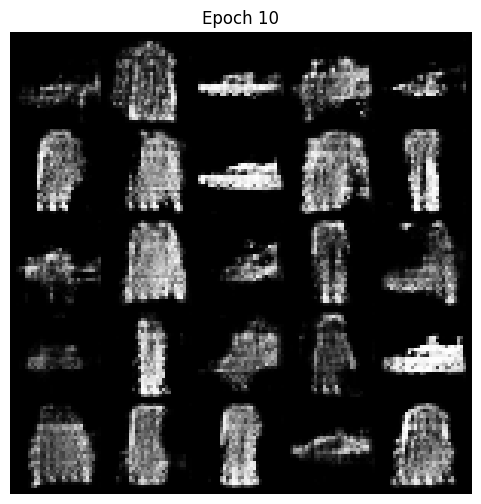

Epoch 11/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/938 [00:00<?, ?it/s]

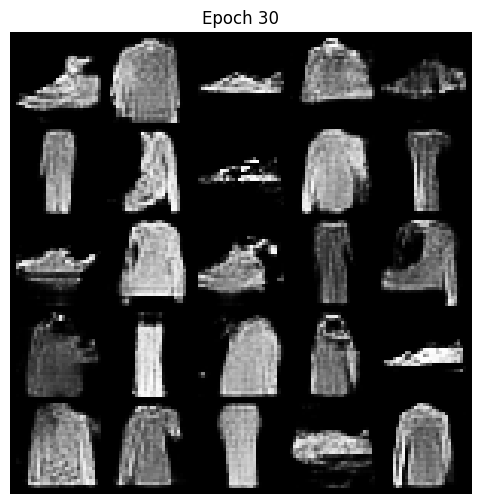

Epoch 31/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/938 [00:00<?, ?it/s]

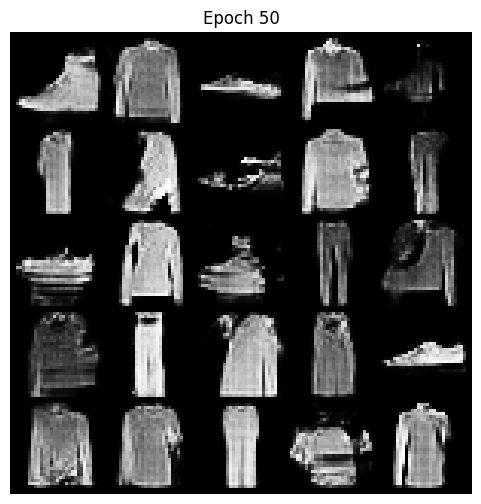

In [ ]:
from tqdm.notebook import tqdm

# Training Loop

epochs = 50
fixed_noise = torch.randn(25, 100, device=device)

def show_generated_images(G, epoch):
    G.eval()
    with torch.no_grad():
        fake_images = G(fixed_noise).detach().cpu()
    G.train()
    grid = torchvision.utils.make_grid(fake_images, nrow=5, normalize=True)
    plt.figure(figsize=(6,6))
    plt.title(f"Epoch {epoch}")
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.axis('off')
    plt.show()

for epoch in range(1, epochs + 1):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for real, _ in progress_bar:
        batch_size = real.size(0)
        real = real.to(device)
        noise = torch.randn(batch_size, 100, device=device)
        fake = G(noise)

        # Train Discriminator
        D.zero_grad()
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        d_loss_real = criterion(D(real), real_labels)
        d_loss_fake = criterion(D(fake.detach()), fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        G.zero_grad()
        g_loss = criterion(D(fake), real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Optional: show losses in progress bar
        progress_bar.set_postfix({
            "D_loss": d_loss.item(),
            "G_loss": g_loss.item()
        })

    if epoch in [10, 30, 50]:
        show_generated_images(G, epoch)


In [ ]:
# Install Pandoc
!apt-get install pandoc -y

# Install full LaTeX
!apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-recommended -y

# 2. Convert the notebook to PDF
!jupyter nbconvert --to pdf "/content/drive/MyDrive/master year 1 section 2/deep learning/hw3/HW3-Q3.ipynb"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc-data
Suggested packages:
  texlive-latex-recommended texlive-xetex texlive-luatex pandoc-citeproc
  texlive-latex-extra context wkhtmltopdf librsvg2-bin groff ghc nodejs php
  python ruby libjs-mathjax libjs-katex citation-style-language-styles
The following NEW packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc
  pandoc-data
0 upgraded, 4 newly installed, 0 to remove and 34 not upgraded.
Need to get 20.6 MB of archives.
After this operation, 156 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [115 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm-extensions0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [25.1 kB